In [0]:
from tensorflow.python.client import device_lib

In [41]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9975672394259487812, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11998678056406308053
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15145022608509329351
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14800692839
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11367764758311379677
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
import os

In [6]:
from zipfile import ZipFile
file_name='signatures.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
import numpy as np
from vgg16 import VGG16
#from resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [0]:
import os
import keras

In [0]:
data_path='signatures'
data_dir_list = os.listdir(data_path)

In [0]:
data_dir_list.sort()

In [79]:
img_data_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
      if(img!='Thumbs.db'):
          img_path = data_path + '/'+ dataset + '/'+ img
          img = image.load_img(img_path, target_size=(224, 224))
          x = image.img_to_array(img)
          x = np.expand_dims(x, axis=0)
          x = preprocess_input(x)
          #x = x/255
          #print('Input image shape:', x.shape)
          img_data_list.append(x)

img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

Loaded the images of dataset-full_forg

Loaded the images of dataset-full_org

(2640, 1, 224, 224, 3)
(1, 2640, 224, 224, 3)
(2640, 224, 224, 3)


In [0]:
num_classes = 2
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

In [0]:
labels[0:1320]=0
labels[1320:]=1

In [0]:
names = ['forged','genuine']

In [83]:
len(labels)

2640

In [0]:
Y = np_utils.to_categorical(labels, num_classes)

In [0]:
#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [89]:
image_input = Input(shape=(224, 224, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

model.summary()

last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_vgg_model2 = Model(image_input, out)
custom_vgg_model2.summary()

# freeze all the layers except the dense layers
for layer in custom_vgg_model2.layers[:-3]:
	layer.trainable = False

custom_vgg_model2.summary()

custom_vgg_model2.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),metrics=['accuracy'])

import time

t=time.time()
#	t = now()
hist = custom_vgg_model2.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

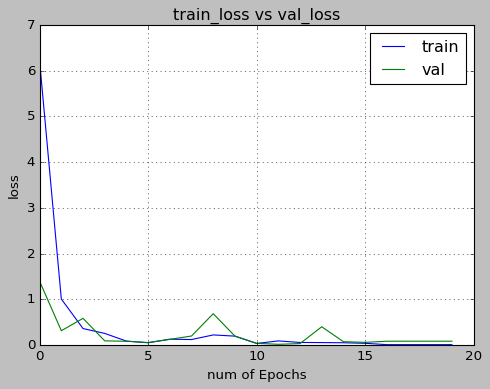

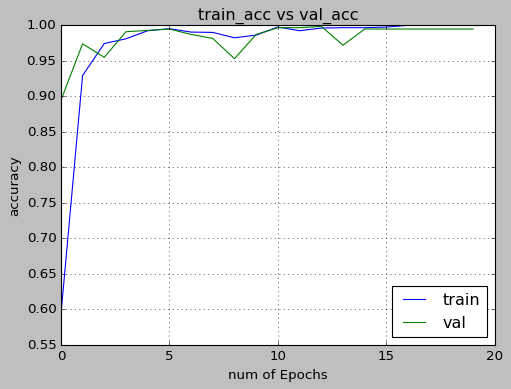

In [120]:
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(20)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [131]:
image_data_list=[]

image_path = 'original_4_16.png'
img = image.load_img(image_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
image_data_list.append(x)

img_data = np.array(image_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0]=1

(1, 1, 224, 224, 3)
(1, 1, 224, 224, 3)
(1, 224, 224, 3)


In [0]:
names = ['forged','genuine']
Y = np_utils.to_categorical(labels, num_classes)
x,y = shuffle(img_data,Y, random_state=2)

In [114]:
(loss, accuracy) = custom_vgg_model2.evaluate(x, y, batch_size=1, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

1/1 [==============================] - 0s 19ms/step
[INFO] loss=0.0000, accuracy: 100.0000%


In [0]:
ans=custom_vgg_model2.predict(x)

In [0]:
ind=np.argmax(ans[0])

In [135]:
ind

1

In [136]:
ans[0]

array([0., 1.], dtype=float32)

In [137]:
ans[0][ind]

1.0

In [138]:
data_dir_list

['full_forg', 'full_org']

In [139]:
Y

array([[0., 1.]], dtype=float32)